In [1]:
import matplotlib as mpl
mpl.use('Agg')

In [2]:
!pip install astropy

In [3]:
from astropy import units as u

In [4]:
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.coordinates as coord
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [6]:
stream_files[:5]

['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

Let's open one:

In [80]:
table = Table.read(stream_files[1], format='fits')


Let's plot it in ra/dec (angle coordinates):

(-90, 90)

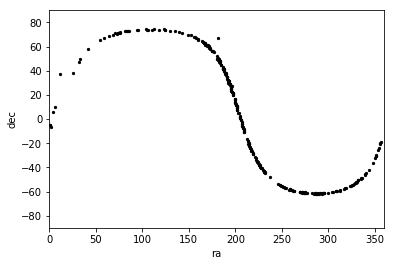

In [81]:
stream.plot('ra', 'dec', kind='scatter', s=5, color='k')
plt.xlim(0, 360)
plt.ylim(-90, 90)

In [82]:
len(stream)

304

Let's just take the part in this box:

In [93]:
stream = table.to_pandas()
stream = stream.query('ra > 200 & ra < 300 & dec < -20 & dec > -70')

In [94]:
len(stream)

91

This is very few stars. Typically we could expect > 1000. 

Now, let's add some foreground in this same region from the Gaia catalog:

In [95]:
!pip install -q astroquery

In [96]:
from astroquery.gaia import Gaia

Now, let's download some random stars from Gaia around this region:

The important part is: "dr2.ra > 44.0 and dr2.ra < 54.0 and dr2.dec > -30.0 and dr2.dec < -10.0" - this represents the box around our data.

This is an SQL query to select 2,000 random stars matching our criteria (which we specify below)

In [128]:
min_ra = 200.0
max_ra = 300.0
min_dec = -70.0
max_dec = -20.0
max_rel_err = 0.5
n_points = 200

qry = f" \n\
select top {n_points} source_id, \n\
dr2.ra, \n\
dr2.dec, \n\
parallax, \n\
parallax_error, \n\
pmra, \n\
pmdec, \n\
phot_g_mean_mag,\n\
phot_bp_mean_mag, \n\
phot_rp_mean_mag, \n\
bp_rp, \n\
bp_g, \n\
g_rp\n\
from gaiadr2.gaia_source as dr2 \n\
where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
and parallax is not null \n\
and parallax_error is not null \n\
and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
and pmra is not null \n\
and pmdec is not null \n\
and phot_g_mean_mag is not null \n\
and phot_bp_mean_mag is not null \n\
and phot_rp_mean_mag is not null \n\
and bp_rp is not null \n\
and bp_g is not null \n\
and g_rp is not null \n\
order by random_index"

data = Gaia.launch_job_async(qry).get_results().to_pandas()

INFO: Query finished. [astroquery.utils.tap.core]


Here is our dataset plotted:

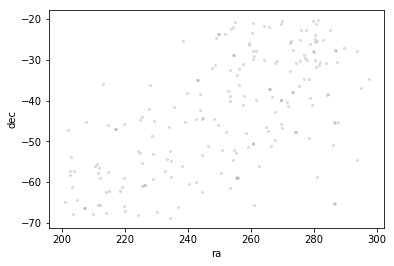

In [129]:
data.plot('ra', 'dec', kind='scatter', s=5, color='k', alpha=0.1)

Now, let's combine these datasets:

In [130]:
data['stream_mask'] = False
stream['stream_mask'] = True
data_to_search = pd.concat((data, stream), axis=0, ignore_index=True, sort=True)

In [131]:
from sklearn.preprocessing import StandardScaler

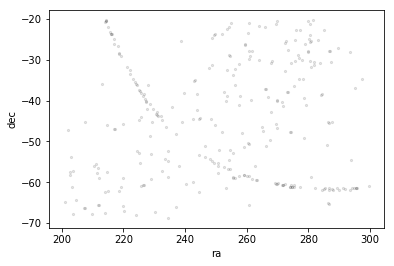

In [132]:
data_to_search.plot('ra', 'dec', kind='scatter', s=5, color='k', alpha=0.1)

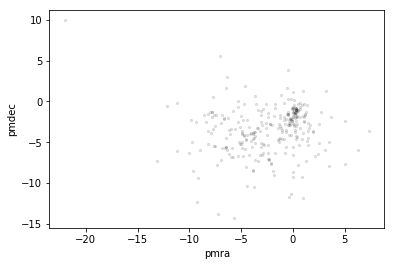

In [133]:
data_to_search.plot('pmra', 'pmdec', kind='scatter', s=5, color='k', alpha=0.1)

Now, let's see if HDBSCAN picks it up:

In [134]:
!pip install -q hdbscan

In [135]:
axes_to_use = ['ra', 'dec', 'pmra', 'pmdec']
label = 'stream_mask'
s = StandardScaler()
#X = s.fit_transform(X=data_to_search[axes_to_use])
X = np.array(data_to_search[axes_to_use])
y = np.array(data_to_search[label])

In [136]:
from hdbscan import HDBSCAN

In [137]:
db = HDBSCAN(metric='euclidean')

In [138]:
out_y = db.fit_predict(X)

In [139]:
np.unique(out_y)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

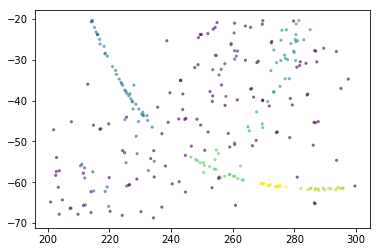

In [140]:
plt.scatter(X[:, 0], X[:, 1], s=5, c=out_y, alpha=0.5)
plt.legend()

Indeed we can see a strip of yellow stars that resembles a stream. Let's take a closer look at label vs true label:

Text(0.5,0,'HDBSCAN Cluster (-1 is noise)')

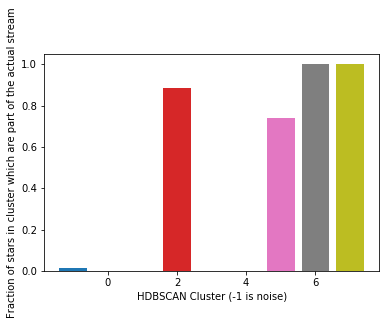

In [141]:
for cur_label in np.unique(out_y):
    mask = out_y == cur_label
    plt.bar(cur_label, y[mask].sum()/mask.sum())

plt.ylabel('Fraction of stars in cluster which are part of the actual stream')
plt.xlabel('HDBSCAN Cluster (-1 is noise)')

Text(0.5,0,'HDBSCAN Cluster (-1 is noise)')

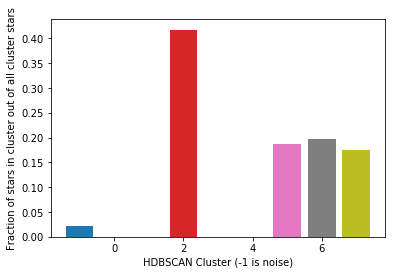

In [142]:
for cur_label in np.unique(out_y):
    mask = out_y == cur_label
    plt.bar(cur_label, y[mask].sum()/y.sum())

plt.ylabel('Fraction of stars in cluster out of all cluster stars')
plt.xlabel('HDBSCAN Cluster (-1 is noise)')


Stuff to test:

- What metrics work well for HDBSCAN?
- What works well for many different streams? (Maybe write a framework to test an algorithm on ~100 streams)?
- Can you try a supervised algorithm to learn to cluster in ra/dec/pmra/pmdec space (as above), and then try on a different stream and detect it?